In [ ]:
!pip install --upgrade keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

--2024-05-20 17:31:47--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  25.0MB/s    in 27s     

2024-05-20 17:32:15 (27.3 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



Удалено изображений: 10
Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.
Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauze

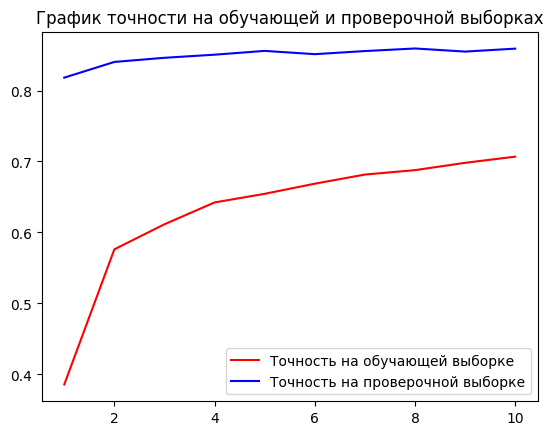

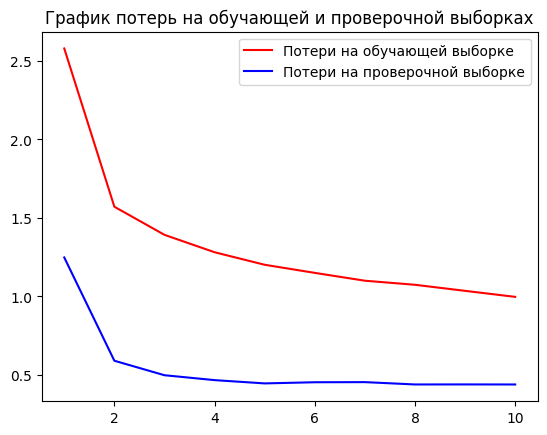

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import tensorflow
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128



# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]

def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    # Note: you may need to experiment with different values of the `weights` parameter
    model = tensorflow.keras.applications.EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pre-trained model
    model.trainable = False

    # Add custom layers on top of the pre-trained model
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="EfficientNetV2B0")
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])

    return model

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

show_plot(history)


Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - acc: 0.7164 - loss: 0.9614 - val_acc: 0.8617 - val_loss: 0.4287
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - acc: 0.7236 - loss: 0.9455 - val_acc: 0.8634 - val_loss: 0.4245
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - acc: 0.7261 - loss: 0.9192 - val_acc: 0.8639 - val_loss: 0.4218
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - acc: 0.7296 - loss: 0.9175 - val_acc: 0.8644 - val_loss: 0.4216
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - acc: 0.7289 - loss: 0.8949 - val_acc: 0.8641 - val_loss: 0.4213


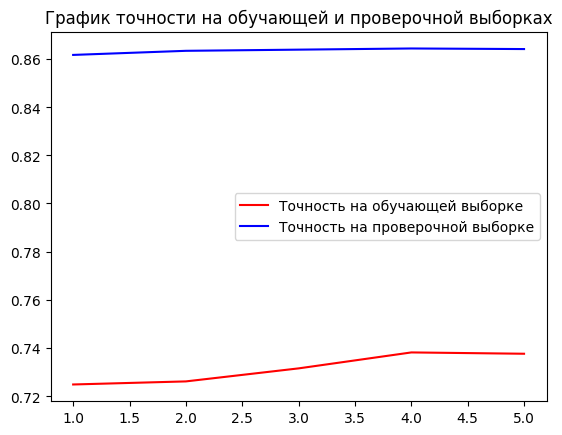

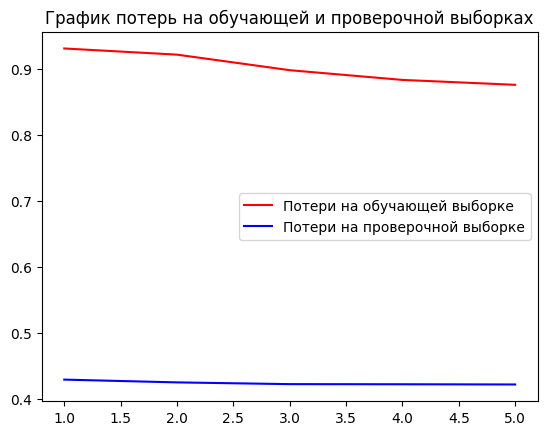

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )

unfreeze_model(model)

epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

show_plot(history)